In [1]:
import os
os.environ['MATPLOTLIBRC'] = "../matplotlibrc" 
BSU_BLUE = "#0033A0"
BSU_ORANGE = "#D64309"
from common import *
data_path = "/home/mikehenry/epoxy-stuff/tuningrxn"

In [2]:
import signac
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from scipy.signal import argrelextrema as argex
import matplotlib.cm as cm
import itertools

            
names={'iso':'Isothermal','lin_ramp':'Linear Ramp','step':'Step'}
colors={'iso':'C0','lin_ramp':'C1','step':'C2'}
markers={'iso':'s','lin_ramp':'P','step':'>'}
linestyles={'iso':'-','lin_ramp':'--','step':'-.'}

def init_project():
    df_index = pd.DataFrame(project.index())
    df_index = df_index.set_index(['_id'])
    statepoints = {doc['_id']: doc['statepoint'] for doc in project.index()}
    #print(statepoints)
    df = pd.DataFrame(statepoints).T.join(df_index)
    df = df.sort_values('T')
    return df
project = signac.get_project(data_path)
df = init_project()


In [3]:
#ADDING A VALUE TO DATA FRAME
df['A']=df.num_a*df.n_mul*4*df.percent_bonds_per_step/100/df.bond_period

#IGNORING NEGATIVE R^2 VALUES SINCE THE MODEL DOES NOT FIT THE DATA AT ALL
df.loc[df['FO_model_R2']<0, 'FO_model_R2'] = None
df.loc[df['SAFO_model_R2']<0, 'SAFO_model_R2'] = None
df.loc[df['SO_model_R2']<0, 'SO_model_R2'] = None
df.loc[df['SASO_model_R2']<0, 'SASO_model_R2'] = None

In [4]:
df_filtered=df[(df.n_particles==50000)&
                 (df.trial==0)&
                 #(df.kT==0.5)&
                 (df.sec_bond_weight==2.0)&
                 (df.t_Final==6000000.0)]
N = len(df_filtered.index)
for i,jobid in enumerate(df_filtered.index):
    print('\r{}/{}'.format(i,N),end='', flush=True)
    job=project.open_job(id=jobid)
    #print(job)
    if job.isfile('out.log'):
        success,r_squared,C,H, ts,X, first_index,last_index = fit_curing_profile_with_model(job,'FO')
        if success:
            df.at[jobid,'FO_model_R2']=r_squared
            df.at[jobid,'FO_model_C']=None
            df.at[jobid,'FO_model_H']=H
        else:
            df.at[jobid,'FO_model_R2']=None
            df.at[jobid,'FO_model_C']=None
            df.at[jobid,'FO_model_H']=None
        success,r_squared,C,H, ts,X, first_index,last_index = fit_curing_profile_with_model(job,'SO')
        if success:
            df.at[jobid,'SO_model_R2']=r_squared
            df.at[jobid,'SO_model_C']=None
            df.at[jobid,'SO_model_H']=H
        else:
            df.at[jobid,'SO_model_R2']=None
            df.at[jobid,'SO_model_C']=None
            df.at[jobid,'SO_model_H']=None
        success,r_squared,C,H, ts,X, first_index,last_index = fit_curing_profile_with_model(job,'SAFO')
        if success:
            df.at[jobid,'SAFO_model_R2']=r_squared
            df.at[jobid,'SAFO_model_C']=C
            df.at[jobid,'SAFO_model_H']=H
        else:
            df.at[jobid,'SAFO_model_R2']=None
            df.at[jobid,'SAFO_model_C']=None
            df.at[jobid,'SAFO_model_H']=None
        success,r_squared,C,H, ts,X, first_index,last_index = fit_curing_profile_with_model(job,'SASO')
        if success:
            df.at[jobid,'SASO_model_R2']=r_squared
            df.at[jobid,'SASO_model_C']=C
            df.at[jobid,'SASO_model_H']=H
        else:
            df.at[jobid,'SASO_model_R2']=None
            df.at[jobid,'SASO_model_C']=None
            df.at[jobid,'SASO_model_H']=None

559/560

dt 0.0
A
0.2    0.945619
0.4    0.950254
0.8    0.959808
1.0    0.960730
2.0    0.928995
Name: mean, dtype: float64
mean [0.945619103017723, 0.950254288906609, 0.9598076788566473, 0.9607301037624483, 0.928995102047589]
sem [0.006392732210594325, 0.012495682509545991, 0.019040485607139702, 0.01716467117011829, 0.015309757691478555]
dt 1e-06
A
0.2    0.948591
0.4    0.956021
0.8    0.965094
1.0    0.966229
2.0    0.931752
Name: mean, dtype: float64
mean [0.94859148878912, 0.9560205476716985, 0.9650941367218119, 0.9662292362702921, 0.9317522846651318]
sem [0.005625036624910638, 0.009481049361207135, 0.014276453108781024, 0.012399245208402064, 0.015227730575043128]
dt 1e-05
A
0.2    0.968161
0.4    0.977488
0.8    0.984524
1.0    0.983401
2.0    0.942708
Name: mean, dtype: float64
mean [0.9681606710891609, 0.9774884845930968, 0.984524089818837, 0.9834009700698025, 0.942708220784915]
sem [0.0025019918928122545, 0.0023519309457530955, 0.0014005409206292304, 0.0013345367141796671, 0.019396878

/home/mikehenry/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


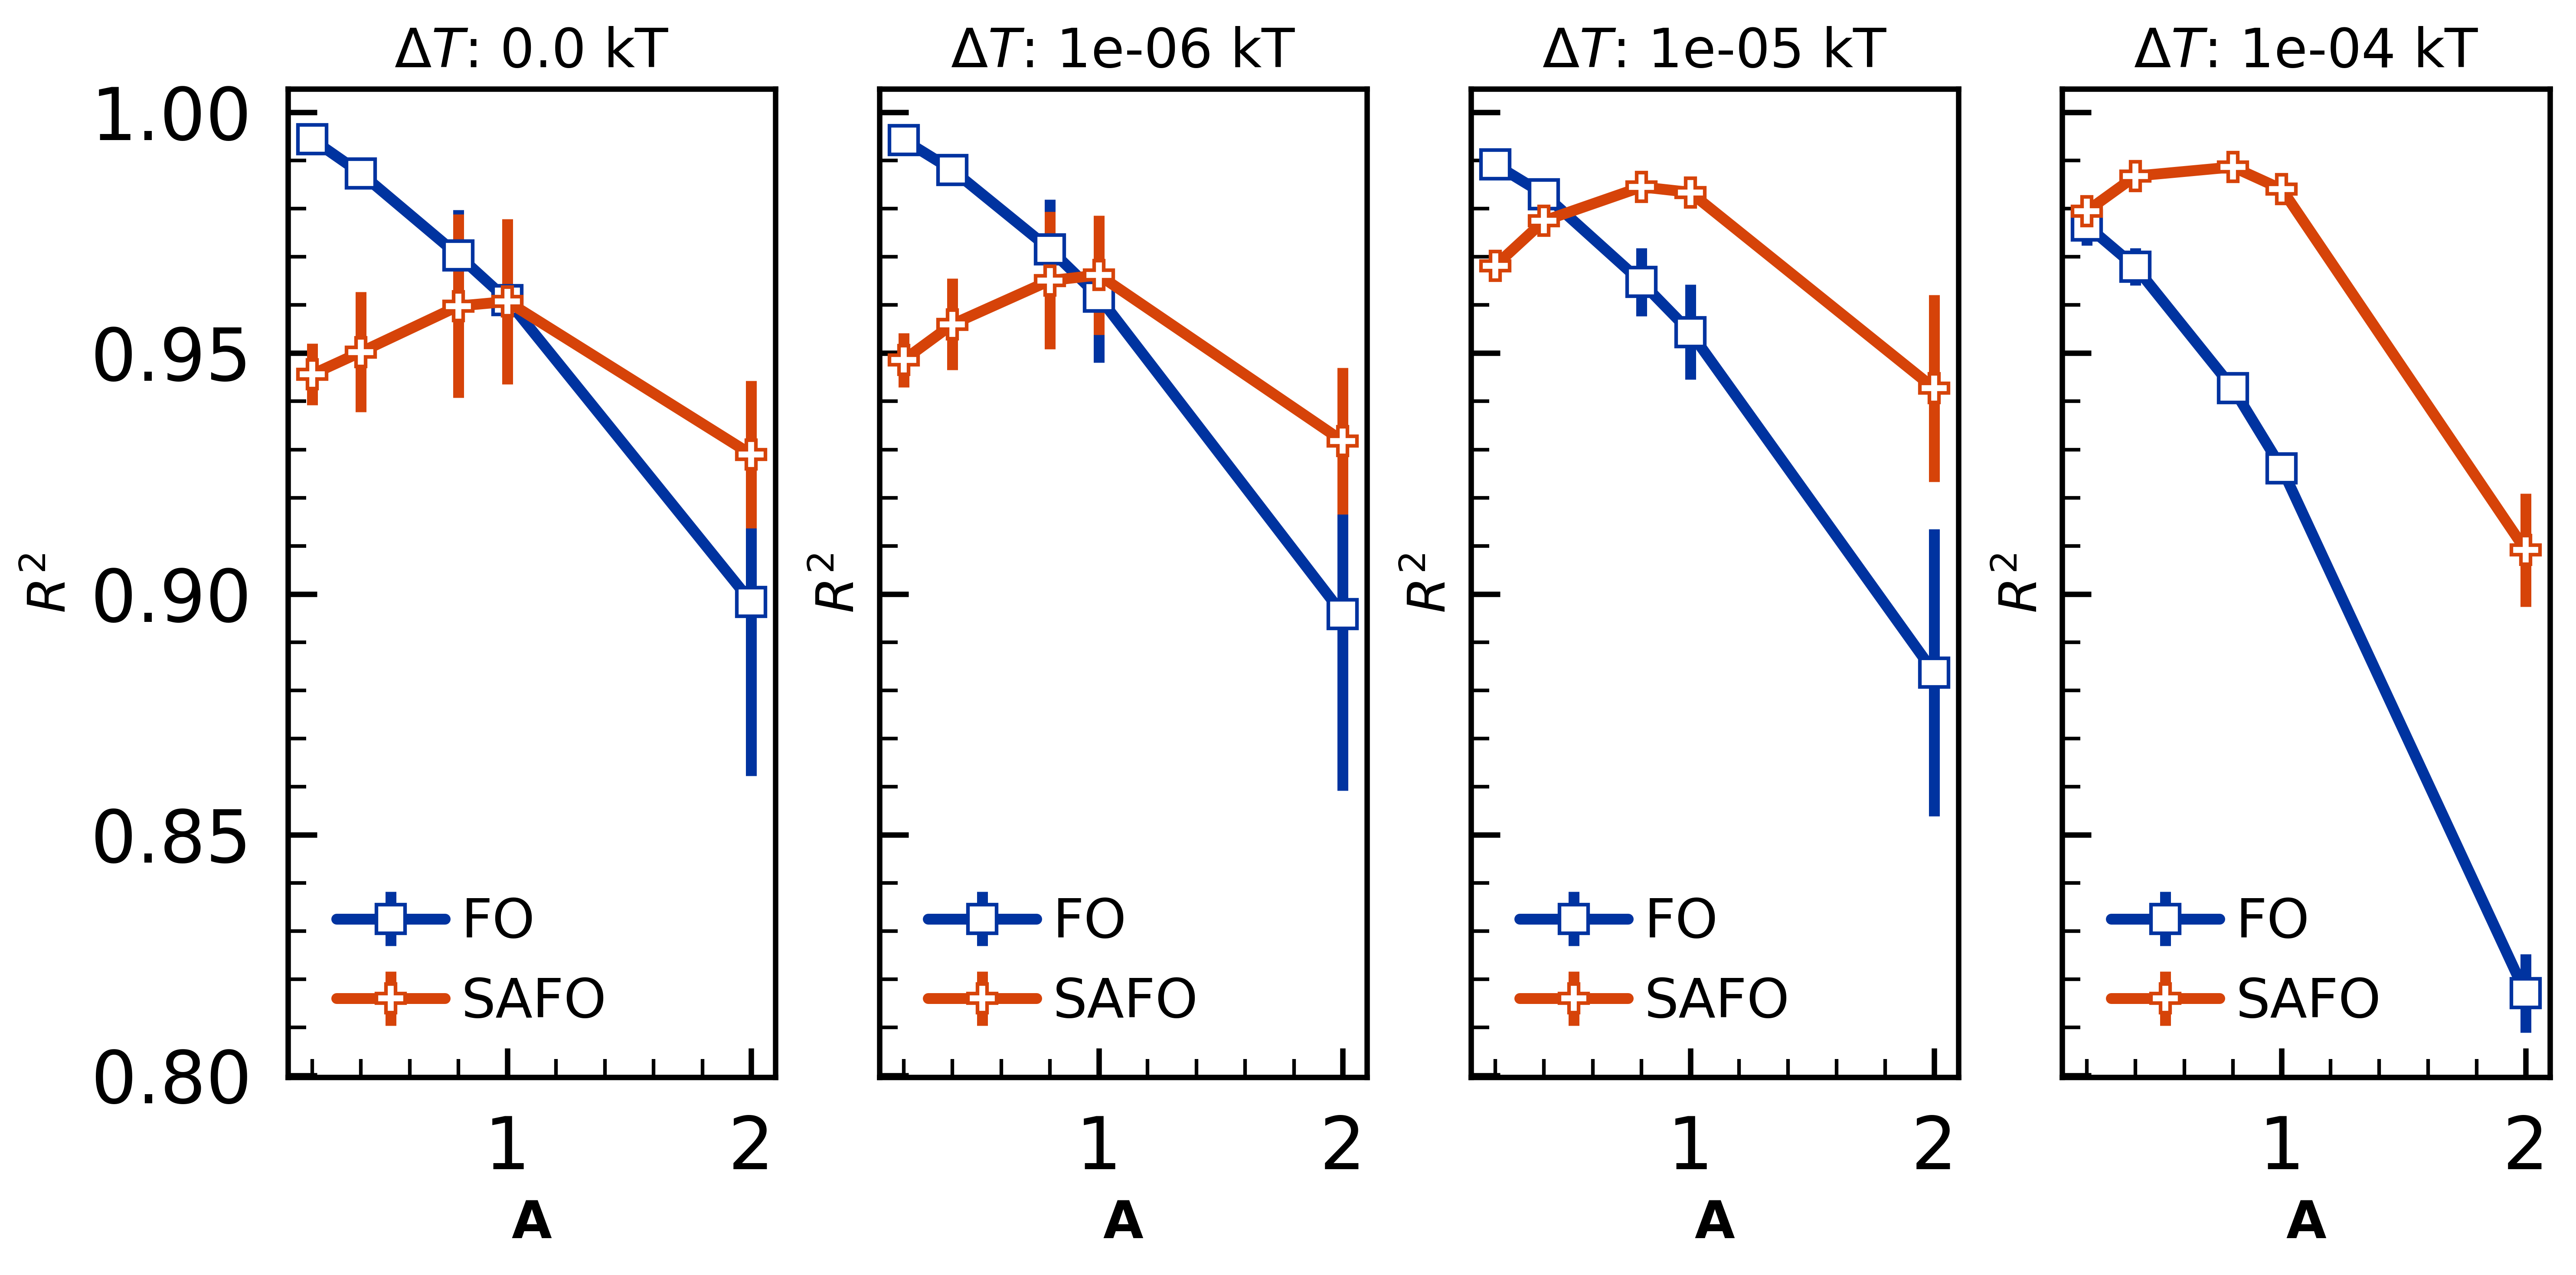

In [30]:
from scipy import stats
fig, axs = plt.subplots(1,4,sharey=True, dpi=600, figsize=(10,5))
#axs = axs.ravel()
df_filtered = df[(df.n_particles==50000)&
                 (df.trial==0)&
                 #(df.kT==0.5)&
                 ((df.kT==0.5)|(df.kT==1.0)|(df.kT==2.0)|(df.kT==4.0)|(df.kT==6.0))&
                 #(df.deltaT==1e-05)&
                 #(df.deltaT==0.0)&
                 (df.sec_bond_weight==2.0)&
                 (df.t_Final==6000000.0)&
                 (df.A<=2)&
                 (df.A>0.1)]
df_sorted = df_filtered.sort_values('A')
models = ['SAFO','SASO']#['FO','SAFO','SO','SASO'] 
for i,(deltaT,df_deltaT) in enumerate(df_sorted.groupby('deltaT')):
    group_agg_mean = df_deltaT.groupby(['A']).aggregate(['mean','sem'])

    colors = itertools.cycle(["royalblue", "g", "orange", "r"])
    markers = itertools.cycle(["s", "P", "D", "H"])

    color = next(colors)
    marker = next(markers)
    if color is 'royalblue':
        facecolor='royalblue'
    else:
        facecolor='white' 
    if True:
        #print("dt", deltaT)
        #print("mean", group_agg_mean.FO_model_R2['mean'].values.tolist())
        #print("sem", group_agg_mean.FO_model_R2['sem'].values.tolist())
        axs[i].errorbar(group_agg_mean.index,
                     group_agg_mean.FO_model_R2['mean'],
                     group_agg_mean.FO_model_R2['sem'],
                     color=BSU_BLUE,
                     marker=marker,
                     markeredgewidth=1, 
                     markerfacecolor="white",
                     markersize=8,
                     #linestyle='--',
                     markeredgecolor=BSU_BLUE,
                     label='FO')

    color = next(colors)
    marker = next(markers)
    if color is 'royalblue':
        facecolor='royalblue'
    else:
        facecolor='white' 
    if True:
        print("dt", deltaT)
        print(group_agg_mean.SAFO_model_R2['mean'])
        print("mean", group_agg_mean.SAFO_model_R2['mean'].values.tolist())
        print("sem", group_agg_mean.SAFO_model_R2['sem'].values.tolist())
        axs[i].errorbar(group_agg_mean.index,
                     group_agg_mean.SAFO_model_R2['mean'],
                     group_agg_mean.SAFO_model_R2['sem'],
                     color=BSU_ORANGE,
                     marker=marker,
                     markeredgewidth=1, 
                     markerfacecolor="white",
                     markersize=8,
                     #linestyle='--',
                     markeredgecolor=BSU_ORANGE,
                     label='SAFO')

    color = next(colors)
    marker = next(markers)
    if color is 'royalblue':
        facecolor='royalblue'
    else:
        facecolor='white' 
    if False:
        axs[i].errorbar(group_agg_mean.index,
                     group_agg_mean.SO_model_R2['mean'],
                     group_agg_mean.SO_model_R2['sem'],
                     color=color,
                     marker=marker,
                     markeredgewidth=1, 
                     markerfacecolor=facecolor,
                     markersize=8,
                     #linestyle='--',
                     markeredgecolor=color,
                     label='SO')

    color = next(colors)
    marker = next(markers)
    if color is 'royalblue':
        facecolor='royalblue'
    else:
        facecolor='white' 
    if False:
        axs[i].errorbar(group_agg_mean.index,
                     group_agg_mean.SASO_model_R2['mean'],
                     group_agg_mean.SASO_model_R2['sem'],
                     color=color,
                     marker=marker,
                     markeredgewidth=1, 
                     markerfacecolor=facecolor,
                     markersize=8,
                     #linestyle='--',
                     markeredgecolor=color,
                     label='SASO')

    if deltaT==0:
        axs[i].set_title('$\Delta T$: {} kT'.format(deltaT),fontsize=15)
    else:
        axs[i].set_title('$\Delta T$: {:.0e} kT'.format(deltaT),fontsize=15)
    axs[i].legend(fontsize=15, loc="lower left")
    axs[i].set_xlabel('A')
    axs[i].set_ylabel('$R^2$')
    #plt.yscale('log')
    #plt.ylim(0.3,1.1)
    axs[i].set_xlim(0.1,2.1)

plt.tight_layout()
plt.savefig("all_delta.png", transparent=True, dpi=300)
plt.show()